In [1]:
from cpr_gym import protocols, wrappers
import gym
import numpy as np
import pandas as pd
import seaborn as sns

In [72]:
def env_fn(alpha, proto=protocols.nakamoto(), steps=2016):
    env = gym.make(
        "cpr_gym:core-v0", proto=proto, alpha=alpha, activation_delay=1, max_steps=steps
    )
    env = wrappers.SparseRelativeRewardWrapper(env)
    return env


def episode(env, policy="honest"):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    acc = 0
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
        acc += reward
    return reward


def measure(
    alpha,
    proto=protocols.nakamoto(),
    policy="honest",
    steps_per_episode=2000,
    steps=5000,
):
    env = env_fn(alpha, proto=proto, steps=steps_per_episode)
    # run measurements
    reward = []
    for i in range(int(np.ceil(steps / steps_per_episode))):
        r = episode(env, policy)
        reward.append(r)
    return np.mean(reward)

In [73]:
alpha = np.arange(0.1, 1.05, 0.1)
steps_per_episode = [8, 16, 32, 64, 128]
protos = [("nakamoto", protocols.nakamoto())]
dfs = []
for proto_s, proto in protos:
    env = env_fn(0.33, proto=proto)
    for policy_s in env.policies():
        for x in alpha:
            relative = []
            for y in steps_per_episode:
                r = measure(x, proto=proto, policy=policy_s, steps_per_episode=y)
                relative.append(r)
            dfs.append(
                pd.DataFrame(
                    dict(
                        alpha=x,
                        steps_per_episode=steps_per_episode,
                        reward=relative,
                        protocol=proto_s,
                        policy=policy_s,
                    )
                )
            )
d = pd.concat(dfs, ignore_index=True)

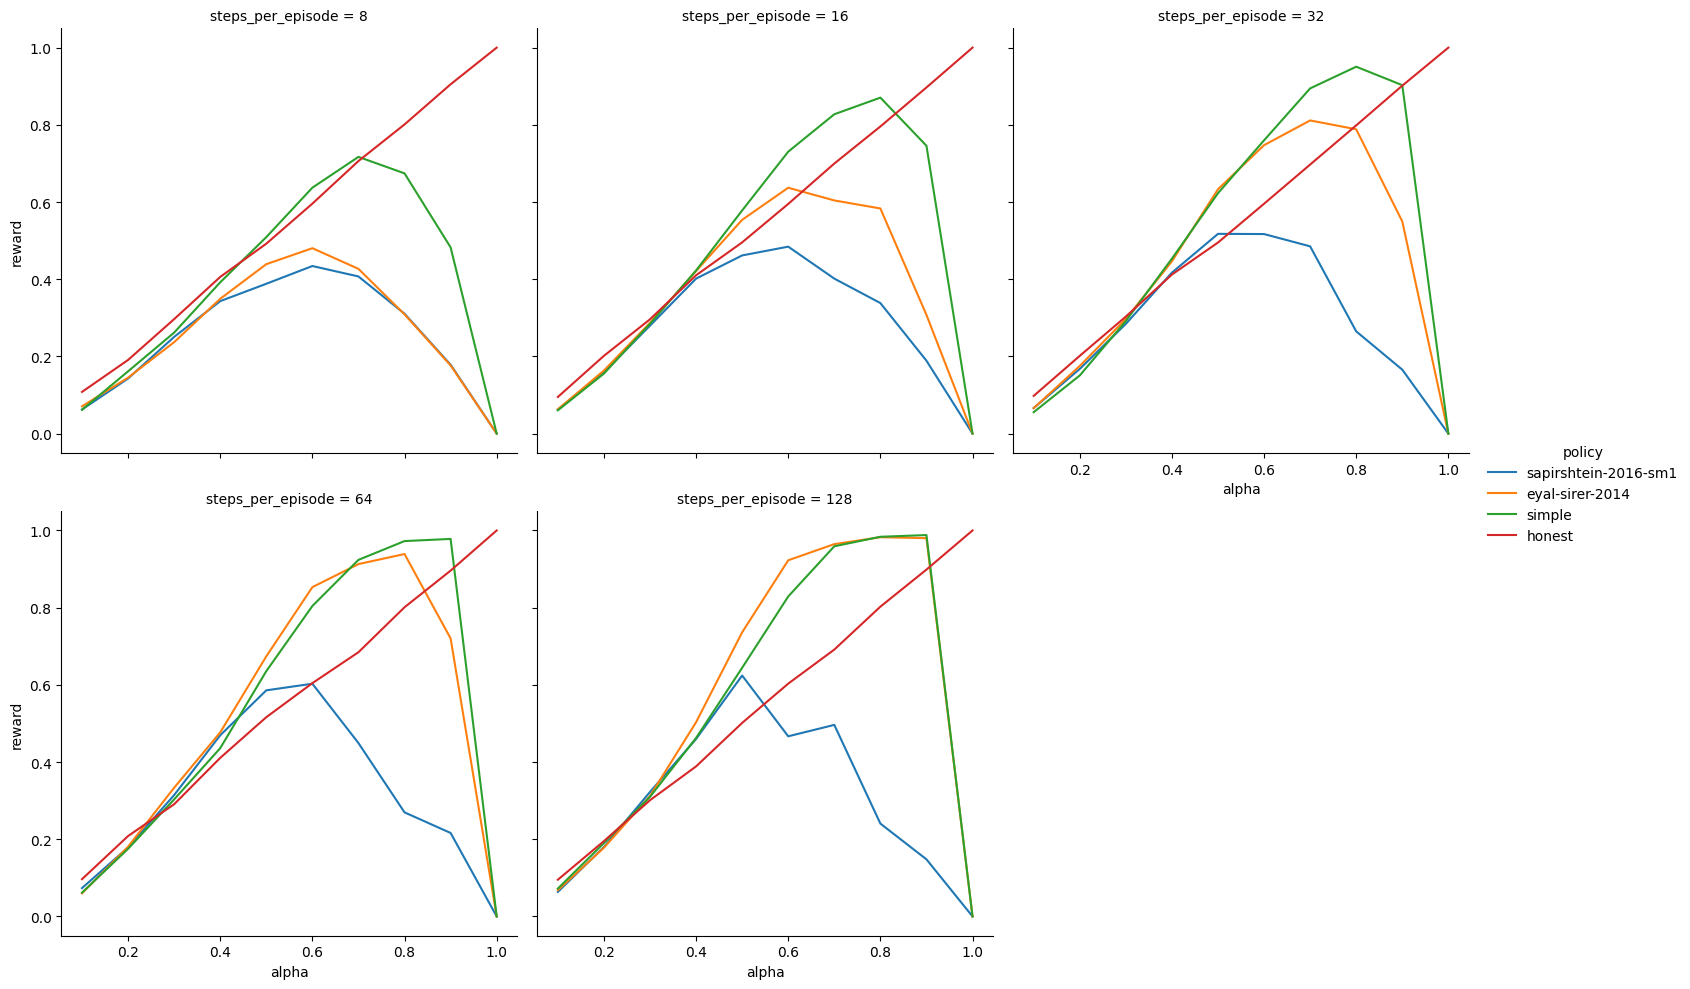

In [76]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    col="steps_per_episode",
    col_wrap=3,
)

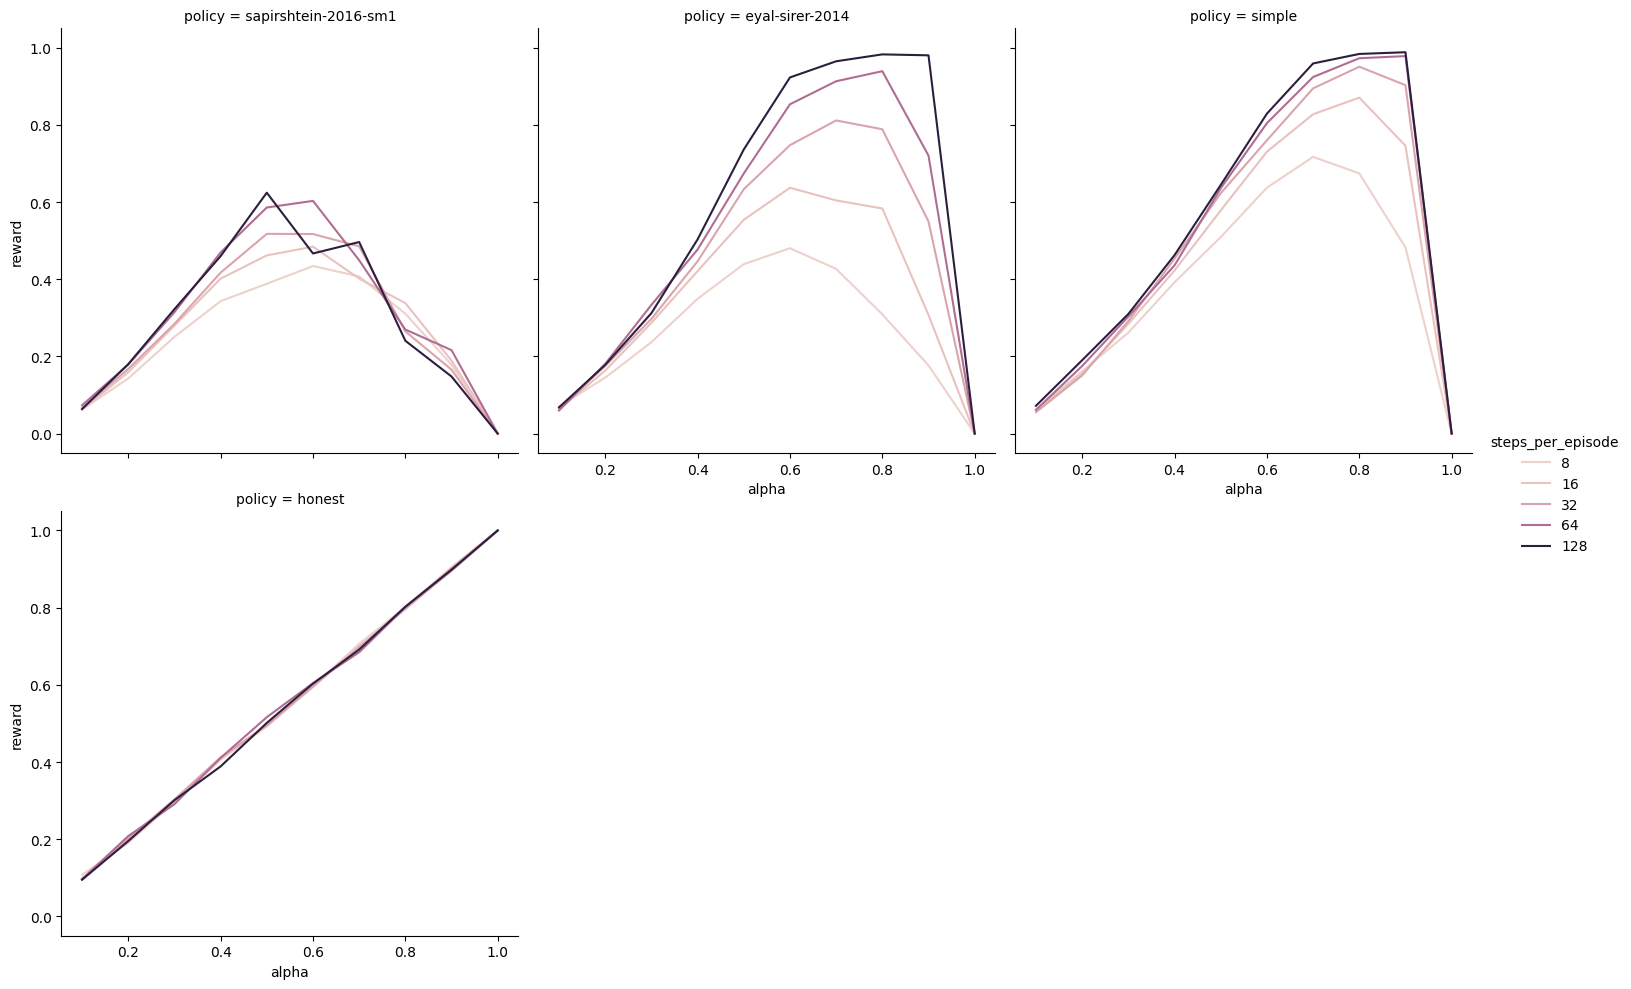

In [77]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="steps_per_episode",
    col="policy",
    col_wrap=3,
)